# Wild Fire Model Evaluation

This notebooks will evaluate severals model on the wildfire dataset in order to make a predecction on fire intensity and CO2 emissions. A down selection will be made to 2-3 models for further hyper-paramater tuning. 

In [1]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

# Import all the models we will likely use for classificaiton

In [2]:
%matplotlib inline

import os
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

import os
import pickle


# Helper function to save estimator
Saves to current working directory

In [3]:
def save_estimator (estimator) :
          
    outpath = estimator.__class__.__name__.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
        f.close()
        
    #print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [4]:
def open_estimator(filename) :
    
    infile = open(filename,'rb')
    estimator = pickle.load(infile)
    infile.close()

    print ("Unpickled file", filename)
    
    return estimator

# Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally

In [5]:
#This helper function allows for a random sample instead of reading everything

import random

def read_random_sample(sample_size, file_name):


    total_records = 1328922 #number of records in file
    skip = sorted(random.sample(range(total_records), total_records-sample_size))
    
    #don't skip the header line of the file
    if (skip[0] == 0):
        skip[0] = 2

        
    df = pd.read_csv(file_name, skiprows=skip)
    return df
    

In [6]:
#Read the data from disk for faster access

#get a sample of the data to save time - comment out if you want all the data
df_fires = read_random_sample(100000, 'data/FireIntensity_Model_June7_Clean.csv')

#use this line to get all the data
#df_fires = pd.read_csv('data/FireIntensity_Model_June7_Clean.csv')



# Show the shape of the file. 
Check data to ensure it's correct.


In [7]:
#show the shape of the data

print(df_fires.head(5))
print (df_fires.shape)
print (df_fires.describe())
print(df_fires.columns)

   latitude  longitude  doy  month  year cluster_reference  fire_region  \
0   34.7912   -95.2437    1      1  2003         2003_1445            3   
1   32.4466  -109.9577    2      1  2003         2003_3004            4   
2   29.8227   -94.0400    3      1  2003           2003_11            0   
3   29.8218   -94.0256    3      1  2003           2003_11            0   
4   31.1589   -86.9416    3      1  2003         2003_1131            2   

   season  covertype  fuelcode  ...  temperature  humidity  precip_intensity  \
0       3          3      1400  ...        51.17      0.47               0.0   
1       3          3      1920  ...        52.58      0.20               0.0   
2       3          3      1140  ...        52.37      0.47               0.0   
3       3          3      1140  ...        52.37      0.47               0.0   
4       3          3      1140  ...        35.91      0.58               0.0   

   visibility  wind_speed  wind_gust  brightness  fire_intensity  br

# Store the key features.
Eliminated the variables related to directly to fire_intensity due to overfit. 

In [8]:
features = ['doy', 'fire_region', 'season', 'covertype', 'prefire_fuel', 
            'fuel_moisture_class', 'temperature', 'humidity', 'precip_intensity', 
            'visibility', 'wind_speed', 'wind_gust']

target = ['fire_intensity']


y = df_fires[target]
X = df_fires[features]


#encode_columns= ['fire_region', 'season', 'covertype', 'fuel_moisture_class'] 
#onehot_list = df_fires[encode_columns]

# Define the models to test
<b>Need to Add a NB Classifier to the list</b>

In [10]:
'''
    models = [
        SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
        SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
        LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
        BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
        RandomForestClassifier(n_estimators=100),
        ]
        
'''


models = [
        LinearSVC(), 
        SGDClassifier(max_iter=100, tol=1e-3),  
        LogisticRegression(solver='lbfgs'),
        BaggingClassifier(), ExtraTreesClassifier(n_estimators=50), 
        RandomForestClassifier(n_estimators=50),
        ]



# Function to Fit and predict the scores of the model. 
Helps in the initial down selection

In [11]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
   
    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
         #('one_hot_encoder', OneHotEncoder(categories='auto')), 
         ('estimator', estimator)
    ])

  
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected = y
    predicted = model.predict(X)
    
   
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='macro')))
   
    save_estimator(estimator)
    
    


# Iterate through the different models

In [12]:
for model in models:
    score_model(X, y, model)

LinearSVC: 0.26015206281208403
SGDClassifier: 0.14440222717046056
LogisticRegression: 0.3510622743026961
BaggingClassifier: 0.8584605496939042
ExtraTreesClassifier: 0.8693604954590779
RandomForestClassifier: 0.8694784305989252


# Function to visualize the model out using yellow brick classification report.
<b> Error is thrown here using the LabelEncoder and one_hot_encoder <b/>

In [19]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        # ('one_hot_encoder', OneHotEncoder(categories='auto')), 
         ('estimator', estimator)
    ])
    
   
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Low', 'Medium', 'High', 'Severe'], 
        cmap="Reds", 
        support=True,
        size=(800, 660)
    )
    
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    
    visualizer.fit(X_train, y_train)  
    
    
    visualizer.score(X_test, y_test)
    
    visualizer.show(outpath=estimator.__class__.__name__ + ".png")  
    visualizer.show()
 

    

# Iterate through the models to visualize

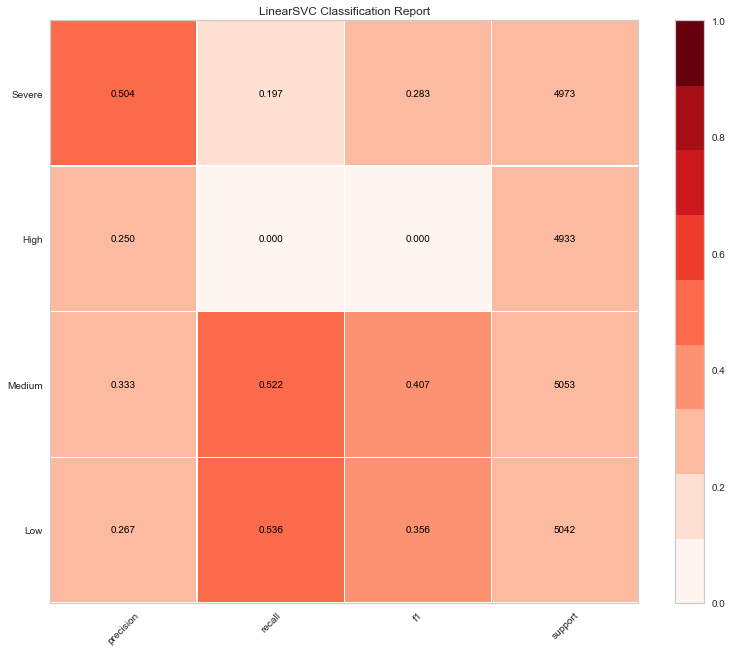

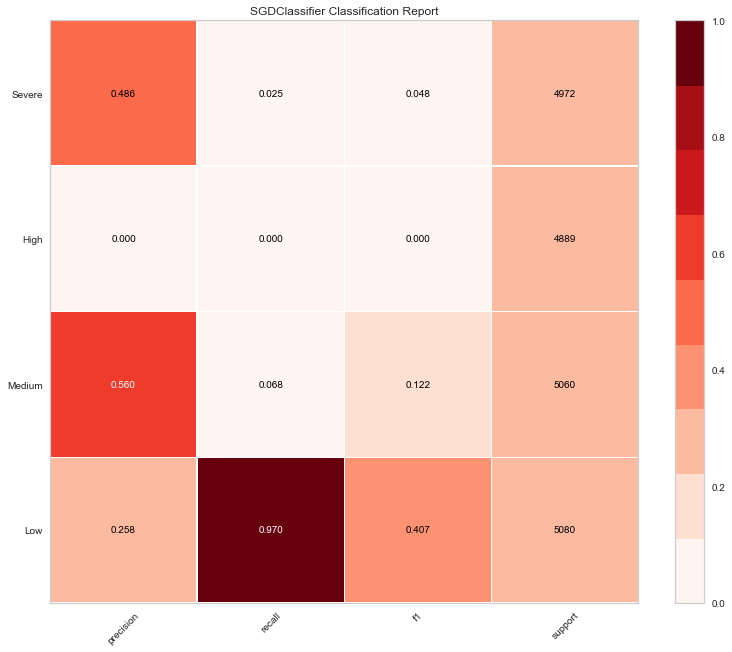

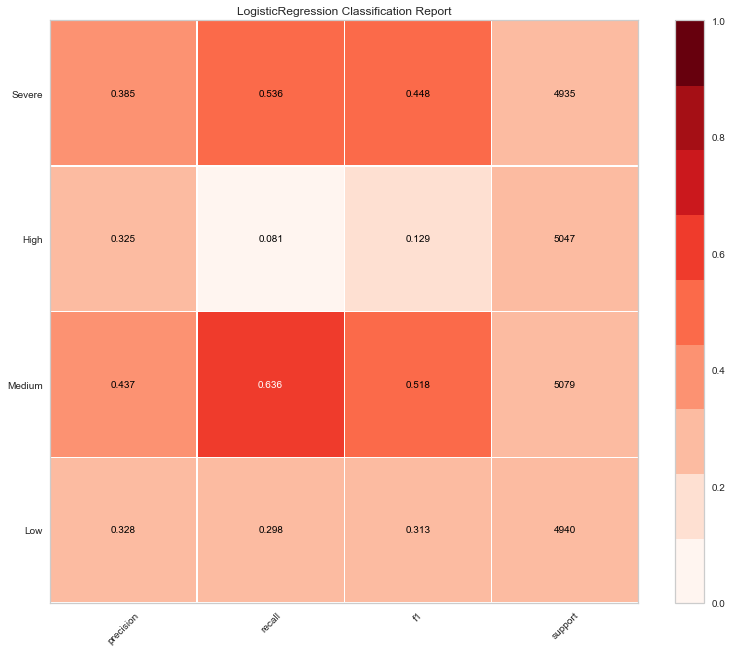

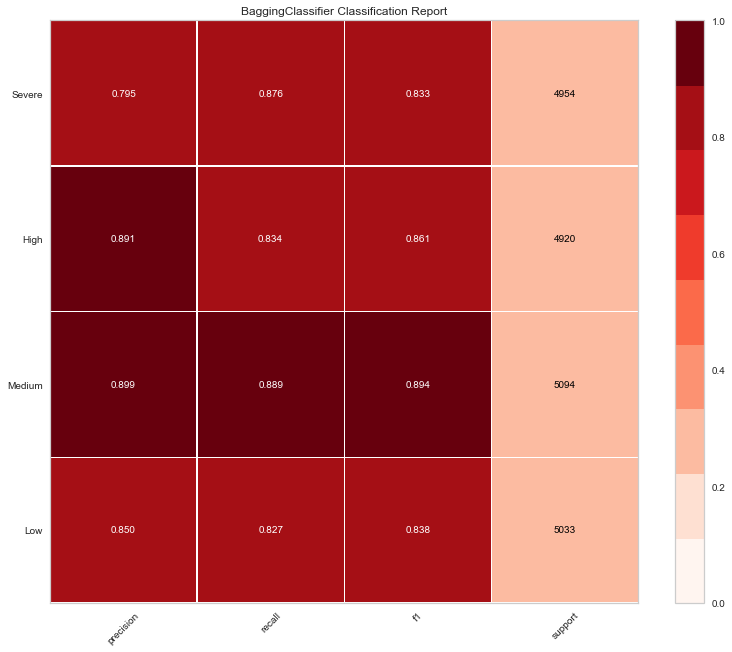

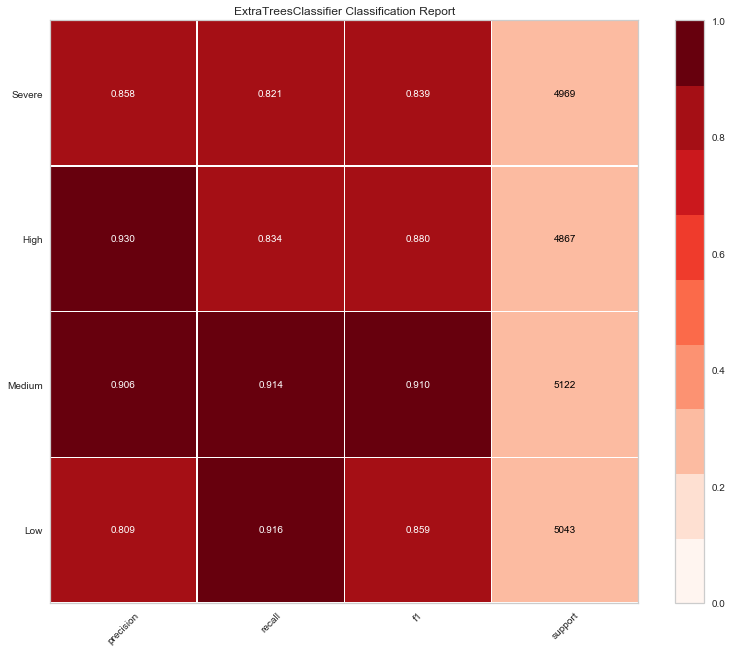

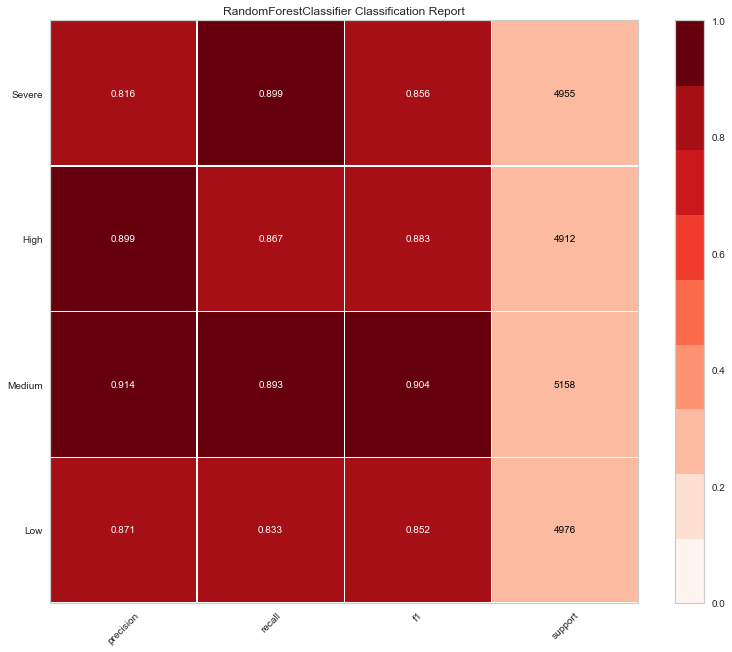

In [20]:
for model in models:
    visualize_model(X, y, model)
    